In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
sns.set(style = "ticks")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("update_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 70 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Control                                   1884 non-null   object 
 1   State                                     1884 non-null   object 
 2   Plan                                      1884 non-null   object 
 3   2018 Fall Enrollment                      1884 non-null   float64
 4   Known_Cases_in_County_per_100k_Residents  1884 non-null   int64  
 5   lat                                       1884 non-null   float64
 6   lng                                       1884 non-null   float64
 7   institution                               1884 non-null   object 
 8   Address                                   1884 non-null   object 
 9   Campus_Size                               1884 non-null   object 
 10  Housing                             

In [4]:
df.Plan.unique()

array(['In-person', 'TBD', 'Hybrid', 'Online'], dtype=object)

In [5]:
df.Plan = df.Plan.map({"In-person":0,"Hybrid":1,"Online":2,"TBD":3})

In [6]:
df.Plan.unique()

array([0, 3, 1, 2], dtype=int64)

In [7]:
df["college_year"]=df["college_year"].astype("str")
df["college_year"].head()

0    4
1    4
2    4
3    4
4    4
Name: college_year, dtype: object

In [8]:
features = [
            'college_year','Campus_Location','Housing', 'Campus_Size', 
            '2018 Fall Enrollment','total_number_faculty',
            'Known_Cases_in_County_per_100k_Residents','Percent_of_State_Cases','Total_Deaths', 
            'AVG_All_Undergrad_Grant/Scholarship','AVG_Federal_Student_Loans_Amount',
            'per_dem', 'per_gop', 
            'pct_change_gdp_avg', 'pct_change_income_avg','lat','lng']

### Feature Engineering

In [9]:
from sklearn.pipeline import Pipeline as pipeline
from sklearn.compose import ColumnTransformer as col_transf
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.preprocessing import StandardScaler

In [10]:
# Identifying numeric & category feature for column transfer
numeric_features =  df[features].select_dtypes(include = "number").columns
category_features = df[features].select_dtypes(include = "object").columns

In [11]:
numeric_features

Index(['2018 Fall Enrollment', 'total_number_faculty',
       'Known_Cases_in_County_per_100k_Residents', 'Percent_of_State_Cases',
       'Total_Deaths', 'AVG_All_Undergrad_Grant/Scholarship',
       'AVG_Federal_Student_Loans_Amount', 'per_dem', 'per_gop',
       'pct_change_gdp_avg', 'pct_change_income_avg', 'lat', 'lng'],
      dtype='object')

In [12]:
category_features

Index(['college_year', 'Campus_Location', 'Housing', 'Campus_Size'], dtype='object')

In [13]:
# Creating pipeline to transform numeric and categorical columns
numeric_transf = pipeline(steps =[("Imputer", SimpleImputer(strategy = "median")),
                          ("scale",StandardScaler())])

category_transf = pipeline(steps = [("Impute", SimpleImputer(strategy = "most_frequent")),
                           ("OneHot",ohe(handle_unknown = "ignore"))])

In [14]:
#Divide the data to "Private" and "Public" for separate analysis
df_public = df[df["Control"]=="Public"][features+["Plan",
       'Tuition_in_state_undergraduate']]
df_private = df[df["Control"]=="Private"][features+["Plan",'Average_Tuition', 'Average_Expense']]

In [15]:
df_public.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 993 entries, 3 to 1880
Data columns (total 19 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   college_year                              993 non-null    object 
 1   Campus_Location                           993 non-null    object 
 2   Housing                                   993 non-null    object 
 3   Campus_Size                               993 non-null    object 
 4   2018 Fall Enrollment                      993 non-null    float64
 5   total_number_faculty                      993 non-null    int64  
 6   Known_Cases_in_County_per_100k_Residents  993 non-null    int64  
 7   Percent_of_State_Cases                    993 non-null    float64
 8   Total_Deaths                              993 non-null    float64
 9   AVG_All_Undergrad_Grant/Scholarship       993 non-null    float64
 10  AVG_Federal_Student_Loans_Amount     

Columns Transformation

In [76]:
# Public columns Transformation
x_public = df_public.drop("Plan",axis = 1)
public_preprocessing_pipeline = col_transf(transformers = [
    ("numeric",numeric_transf,list(numeric_features)+['Tuition_in_state_undergraduate']),
    ("category",category_transf,list(category_features))])
x_public_transf = public_preprocessing_pipeline.fit_transform(x_public)
y_public_transf = df_public["Plan"]

x_public_df = pd.DataFrame(x_public_transf,columns = 
                           list(numeric_features)+['Tuition_in_state_undergraduate']+
                           list(public_preprocessing_pipeline.transformers_[1][1].named_steps['OneHot'].get_feature_names(list(category_features))))

# Private columns Transformations
x_private = df_private.drop("Plan",axis = 1)
private_preprocessing_pipeline = col_transf(transformers = [
    ("numeric",numeric_transf,list(numeric_features)+['Average_Tuition',"Average_Expense"]),
    ("category",category_transf,list(category_features))])
x_private_transf = private_preprocessing_pipeline.fit_transform(x_private)
y_private_transf = df_private["Plan"]

x_private_df = pd.DataFrame(x_private,columns = 
                            list(numeric_features)+['Average_Tuition', 'Average_Expense']+
                            list(private_preprocessing_pipeline.transformers_[1][1].named_steps['OneHot'].get_feature_names(list(category_features))))


In [77]:
print("The shape of feature in Public DF is:",x_public_transf.shape,"\nThe shape of feature in Private DF is:",x_private_transf.shape)

The shape of feature in Public DF is: (993, 28) 
The shape of feature in Private DF is: (891, 29)


In [78]:
df.Plan = df.Plan.map({"In-person":0,"Hybrid":1,"Online":2,"TBD":3})

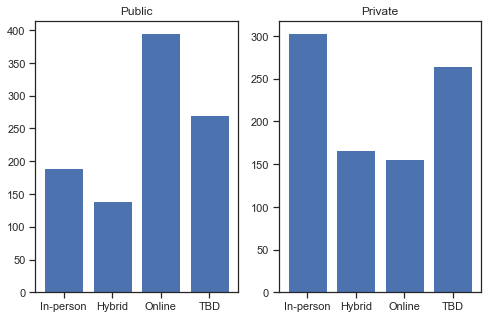

In [79]:
x=[0,1,2,3]
category = ["In-person","Hybrid","Online","TBD"]
fig,axes = plt.subplots(nrows=1, ncols=2,figsize = (8,5))
axes[0].bar(y_public_transf.value_counts().index.to_list(),y_public_transf.value_counts().tolist())
axes[1].bar(y_private_transf.value_counts().index.to_list(),y_private_transf.value_counts().tolist())
plt.setp(axes, xticks=x, xticklabels=category)
axes[0].set_title("Public")
axes[1].set_title("Private")
plt.show()

In [80]:
y_public_transf.value_counts(normalize=True)

2    0.397784
3    0.271903
0    0.190332
1    0.139980
Name: Plan, dtype: float64

In [81]:
y_private_transf.value_counts(normalize=True)

0    0.340067
3    0.297419
1    0.187430
2    0.175084
Name: Plan, dtype: float64

### Feature Selection

### Building pipeline for modeling

In [35]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression as lregression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [30]:
x_public_train,x_public_test,y_public_train,y_public_test = train_test_split(x_public_transf,y_public_transf,test_size = 0.3,random_state = 50)
x_private_train,x_private_test,y_private_train,y_private_test = train_test_split(x_private_transf,y_private_transf,test_size = 0.3,random_state = 50)

In [31]:
### Model
lreg = lregression()
svc = SVC()
gnb = GaussianNB()
rfc = RandomForestClassifier()
knn = KNeighborsClassifier()

In [32]:
param_grid_lreg = {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
     "fit_intercept": [True,False],
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]}

param_grid_svc = {"C":[0.001,0.01,0.1,10,50],
                 "kernel": ["linear","rbf"],
                 "gamma":[1, 0.1, 0.01, 0.001, 0.0001]}
param_grid_rfc = {"n_estimators" : [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)],
                  "max_features": ['auto', 'sqrt',"log2"],
                  "max_depth": [int(x) for x in np.linspace(5, 20, num = 10)],
                  "min_samples_split" : [2, 5, 10],
                  "min_samples_leaf": [1, 2, 4],
                  "bootstrap" : [True, False],
                  "criterion" : ["gini","entropy","mse"]}
param_grid_knn = {"n_neighbors": list(range(1,30)),
                 "algorithm": ["auto","kd_tree","brute"],
                 "leaf_size": list(range(1,40)),
                 "p": [1,2]}

In [33]:
param_grids = [param_grid_lreg,param_grid_svc,param_grid_rfc,param_grid_knn]
models = [lreg,svc,rfc,knn]
names = ["Logistic Regression","Support Vector Machine","Random Forest","KNN"]

In [89]:
def run_model(x_train,x_test,y_train,y_test,model,param):
    clf = GridSearchCV(model,param,cv = 5, n_jobs = -1, verbose = True)
    clf.fit(x_train,y_train)
    best_param = clf.best_params_
    y_pred_test = clf.best_estimator_.predict(x_test)
    result = classification_report(y_test,y_pred_test,output_dict = True)
    result = pd.DataFrame(result).transpose()
    return best_param, result

In [94]:
svc_params_public, svc_report_public = run_model(x_public_train,x_public_test,y_public_train,y_public_test,svc,param_grid_svc)
rfc_params_public, rfc_report_public = run_model(x_public_train,x_public_test,y_public_train,y_public_test,rfc,param_grid_rfc)
knn_params_public, knn_report_public = run_model(x_public_train,x_public_test,y_public_train,y_public_test,knn,param_grid_knn)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 227 out of 250 | elapsed:    8.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 16200 candidates, totalling 81000 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 11226 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 12776 tasks      | elapsed: 33

Fitting 5 folds for each of 6786 candidates, totalling 33930 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 9928 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 11798 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 12948 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 14876 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 20276 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 26076 tasks 

In [95]:
svc_params_private, svc_report_private = run_model(x_private_train,x_private_test,y_private_train,y_private_test,svc,param_grid_svc)
rfc_params_private, rfc_report_private = run_model(x_private_train,x_private_test,y_private_train,y_private_test,rfc,param_grid_rfc)
knn_params_private, knn_report_private = run_model(x_private_train,x_private_test,y_private_train,y_private_test,knn,param_grid_knn)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 227 out of 250 | elapsed:   18.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   25.9s finished
C:\Users\Petelindan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 16200 candidates, totalling 81000 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 11226 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done 12776 tasks      | elapsed: 38

Fitting 5 folds for each of 6786 candidates, totalling 33930 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 7000 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 11400 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 16600 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 22600 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 29400 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 33930 out of 33930 | elapsed:  1.2min finished


In [109]:
y_public_test.value_counts()

2    125
3     75
1     49
0     49
Name: Plan, dtype: int64

In [108]:
rfc_report_public

,precision,recall,f1-score,support
0,0.377049,0.469388,0.418182,49.000000
1,0.000000,0.000000,0.000000,49.000000
2,0.576159,0.696000,0.630435,125.000000
3,0.357143,0.400000,0.377358,75.000000
accuracy,0.469799,0.469799,0.469799,0.469799
macro avg,0.327588,0.391347,0.356494,298.000000
weighted avg,0.393560,0.469799,0.428178,298.000000


In [110]:
rfc_report_private

,precision,recall,f1-score,support
0,0.446809,0.677419,0.538462,93.000000
1,0.444444,0.226415,0.300000,53.000000
2,0.538462,0.145833,0.229508,48.000000
3,0.459770,0.540541,0.496894,74.000000
accuracy,0.455224,0.455224,0.455224,0.455224
macro avg,0.472371,0.397552,0.391216,268.000000
weighted avg,0.466335,0.455224,0.424491,268.000000


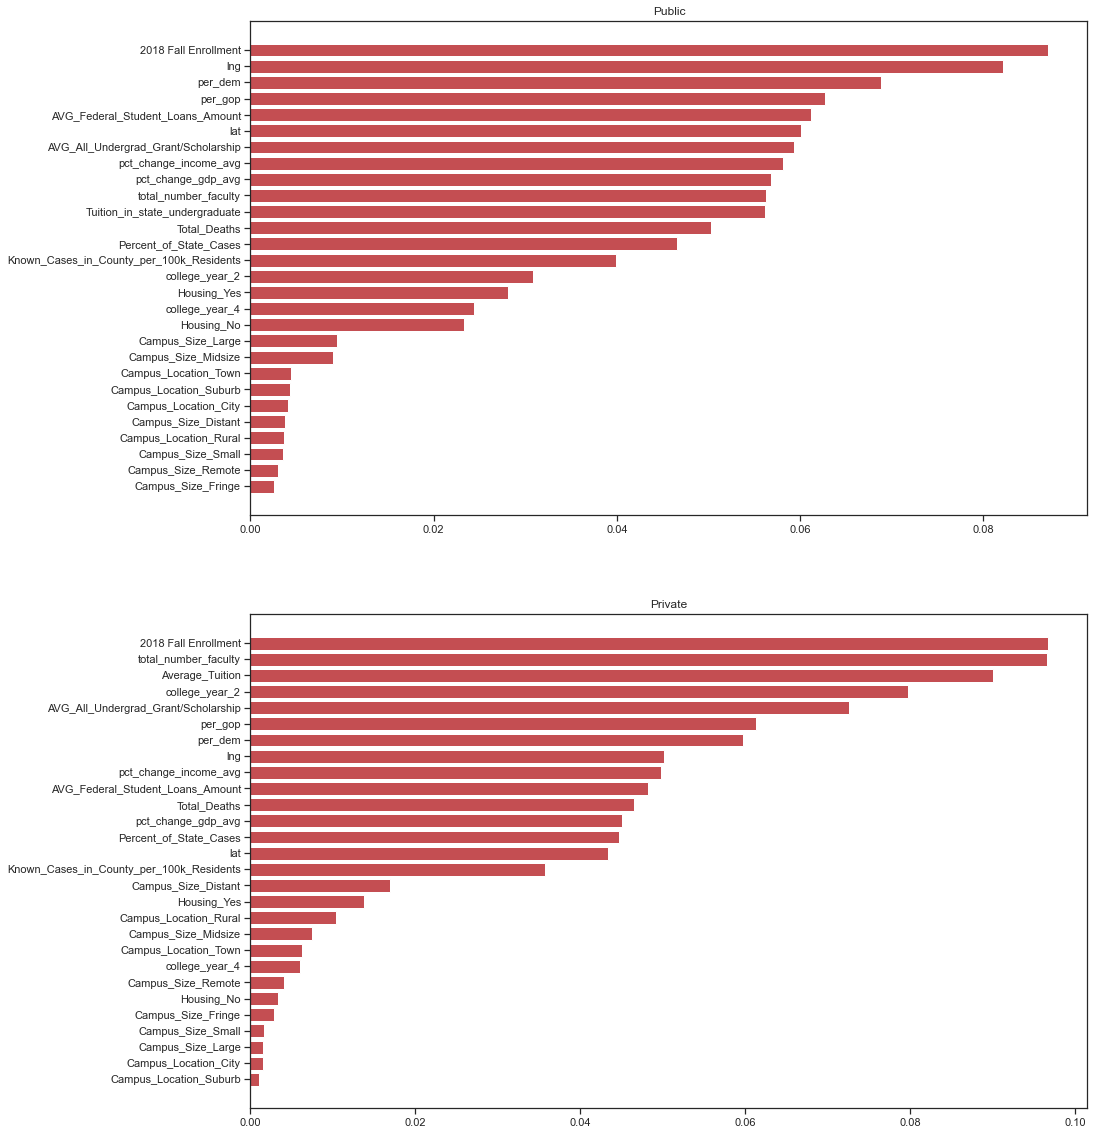

In [104]:
rfc_public = RandomForestClassifier(bootstrap= True, criterion= 'entropy', max_depth=6, max_features= 'log2', min_samples_leaf= 4, min_samples_split= 2, n_estimators= 100)
rfc_public.fit(x_public_train,y_public_train)
variable_name = (list(numeric_features)+['Tuition_in_state_undergraduate']+
                           list(public_preprocessing_pipeline.transformers_[1][1].named_steps['OneHot'].get_feature_names(list(category_features))))
public_importances = rfc_public.feature_importances_
result_public = pd.DataFrame(list(zip(variable_name,public_importances)),columns = ["Name","Score"])
result_public = result_public.sort_values(by = "Score",ascending = True)
result_public

rfc_private = RandomForestClassifier(bootstrap= True, criterion= 'entropy', max_depth=8, max_features= 'log2', min_samples_leaf= 4, min_samples_split= 5, n_estimators= 144)
rfc_private.fit(x_private_train,y_private_train)
variable_name = (list(numeric_features)+['Average_Tuition']+
                            list(private_preprocessing_pipeline.transformers_[1][1].named_steps['OneHot'].get_feature_names(list(category_features))))
private_importances = rfc_private.feature_importances_
result_private = pd.DataFrame(list(zip(variable_name,private_importances)),columns = ["Name","Score"])
result_private = result_private.sort_values(by = "Score",ascending = True)# Plot the impurity-based feature importances of the forest

fig,ax = plt.subplots(nrows=2, ncols=1,figsize = (15,20))
ax[0].barh(result_public["Name"], result_public["Score"],
        color="r", align="center")
ax[1].barh(result_private["Name"], result_private["Score"],
        color="r", align="center")
ax[0].set_title("Public")
ax[1].set_title("Private")
plt.show()


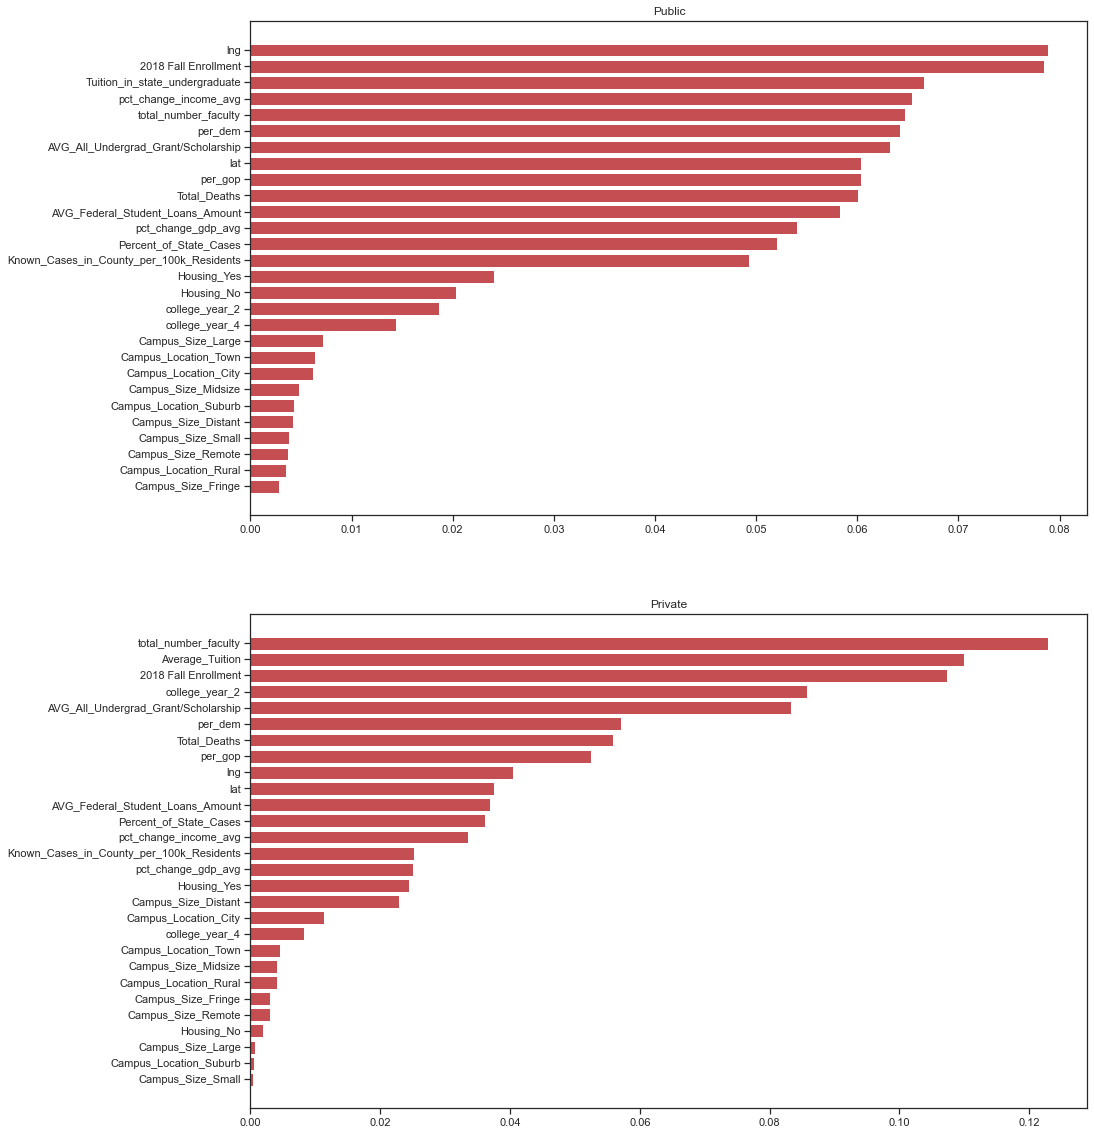

In [103]:
rfc_public = RandomForestClassifier(bootstrap= True, criterion= 'gini', max_depth=11, max_features= 'sqrt', min_samples_leaf= 4, min_samples_split= 10, n_estimators= 188)
rfc_public.fit(x_public_transf, y_public_transf)
variable_name = (list(numeric_features)+['Tuition_in_state_undergraduate']+
                           list(public_preprocessing_pipeline.transformers_[1][1].named_steps['OneHot'].get_feature_names(list(category_features))))
importances = rfc_public.feature_importances_
result_public = pd.DataFrame(list(zip(variable_name,importances)),columns = ["Name","Score"])
result_public = result_public.sort_values(by = "Score",ascending = True)
result_public

rfc_private = RandomForestClassifier(bootstrap= True, criterion= 'entropy', max_depth= 5, max_features= 'auto', 
                                     min_samples_leaf= 4, min_samples_split= 10, n_estimators= 188)
rfc_private.fit(x_private_transf, y_private_transf)
variable_name = (list(numeric_features)+['Average_Tuition']+
                            list(private_preprocessing_pipeline.transformers_[1][1].named_steps['OneHot'].get_feature_names(list(category_features))))
importances = rfc_private.feature_importances_
result_private = pd.DataFrame(list(zip(variable_name,importances)),columns = ["Name","Score"])
result_private = result_private.sort_values(by = "Score",ascending = True)# Plot the impurity-based feature importances of the forest

fig,ax = plt.subplots(nrows=2, ncols=1,figsize = (15,20))
ax[0].barh(result_public["Name"], result_public["Score"],
        color="r", align="center")
ax[1].barh(result_private["Name"], result_private["Score"],
        color="r", align="center")
ax[0].set_title("Public")
ax[1].set_title("Private")
plt.show()


In [202]:
fig.savefig("Feature Importance.png")